## HW1 - Скажи мне, кто твой друг, и я скажу, какой у тебя clustering coefficient

### Цели занятия
В этом домашнем задании вам предлагается провести исследование по кластеризации временных рядов, основанное на данных о потребительском поведении.

### Описание/Пошаговая инструкция выполнения домашнего задания:
Цель задания — выявить группы потребителей с похожими паттернами (шаблонами поведенческой активности) покупок на основе временных рядов их транзакций.

### Ссылка на набор данных:
https://archive.ics.uci.edu/dataset/352/online+retail

### Типовые выполнения задания:

* Для начала проведите исследовательский анализ данных, Откорректируйте верно формат даты и времени, обработайте пропуски и выбросы, если они имеются.
ВНИМАНИЕ! Дополнительно можно выполнить извлечение признаков из табличных данных. Извлеките признаки из временных рядов, такие как:
  * Общее количество покупок за период
  * Средняя сумма покупки
  * Частота покупок (количество транзакций в неделю/месяц)
  * Сезонные паттерны (например, увеличение покупок в праздничные дни)
  * Временные интервалы между покупками и др.
* Преобразуйте данные в формат временных рядов, агрегируя транзакции по дням/неделям/месяцам обобщая количество или стоимость покупок.
* Нормализуйте данные, чтобы устранить влияние масштабов различных клиентов.
* Выполните кластеризацию временных рядов. Примените алгоритмы кластеризации, такие как K-средних (с различными метриками, в том числе DTW), DBSCAN или иерархическая кластеризация, к временным рядам. Для алгоритма K-средних определите оптимальное количество кластеров с помощью методов, таких как метод локтя или анализ силуэта.
* Анализ результатов: проанализируйте полученные кластеры, чтобы понять, какие группы потребителей были выделены. Определите характеристики каждой группы (например, "частые покупатели", "покупатели со средним чеком", "покупатели с сезонными паттернами").
* Визуализируйте результаты кластеризации с помощью соответствующих графиков и диаграмм, чтобы продемонстрировать различия между кластерами.

In [1]:
!pip install tslearn

In [2]:
import os
import requests
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from datetime import timedelta

In [3]:
#Константы
RANDOM_SEED=42

### Чтение данных

In [4]:
def downloader():
    base_url = 'https://archive.ics.uci.edu/static/public/352/online+retail.zip'

    download_response = requests.get(base_url)
    with open('/online+retail.zip', 'wb') as f:
        f.write(download_response.content)

    zip_path = ('/online+retail.zip')

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()

In [5]:
downloader()

In [6]:
data = pd.read_excel("Online Retail.xlsx")

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
data.shape

(541909, 8)

In [9]:
data.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


Пропуски в колонках `Description` и `CustomerID` являются критичными для нас. Поэтому придется удалить записи с пропусками.

In [10]:
data = data.dropna()

Приведем колонку `CustomerID` к типу int.

In [11]:
data['CustomerID'] = data['CustomerID'].astype('int')

<ipython-input-11-bb21ca235a68>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['CustomerID'] = data['CustomerID'].astype('int')


Поищем и удалим дубли.

In [12]:
data[data.duplicated()].count()

,0
InvoiceNo,5225
StockCode,5225
Description,5225
Quantity,5225
InvoiceDate,5225
UnitPrice,5225
CustomerID,5225
Country,5225


Дублей оказалось довольно много.

In [13]:
data = data.drop_duplicates()

In [14]:
data[data.duplicated()].count()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [15]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [16]:
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,401604.000000,401604,401604.000000,401604.000000
mean,12.183273,2011-07-10 12:08:23.848567552,3.474064,15281.160818
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13939.000000
50%,5.000000,2011-07-29 15:40:00,1.950000,15145.000000
75%,12.000000,2011-10-20 11:58:30,3.750000,16784.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,250.283037,NaN,69.764035,1714.006089


### EDA

In [17]:
## Функции для графиков
def hist_with_wiskers(df, col, target=None):
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(f'Гистограмма для {col}', fontsize=16)
    axes[0].set_ylabel('Количество', fontsize=14)
    if target != None:
        sns.histplot(df, bins=20, kde=True, ax=axes[0], hue=target, x=col)
    else:
        sns.histplot(df, bins=20, kde=True, ax=axes[0], x=col)
    axes[1].set_title(f'График ящик с усами для {col}', fontsize=16)
    sns.boxplot(data=df, ax=axes[1], y=col)
    axes[1].set_ylabel(col, fontsize=14)
    plt.show()

def build_barplot(data, x, y, hue, title, x_label, y_label, figsize=(10,6)):
    plt.figure(figsize=figsize)
    plot = sns.barplot(data=data,
                           x=x,
                           y=y,
                           palette="coolwarm")
    plot.set_title(title, fontsize=14)
    plot.set_xlabel(x_label, fontsize=12)
    plot.set_ylabel(y_label, fontsize=12)


def categoral_unique(df, col, head=10):

    order = df[col].value_counts().index
    if head != None:
      order = df[col].value_counts().iloc[:head].index

    plt.figure(figsize=(8,6))
    plot = sns.countplot(y=col, data=df, order = order)
    plot.set_title(f'Рапределение по {col}', fontsize=16)
    plot.set_xlabel('Количество', fontsize=14)

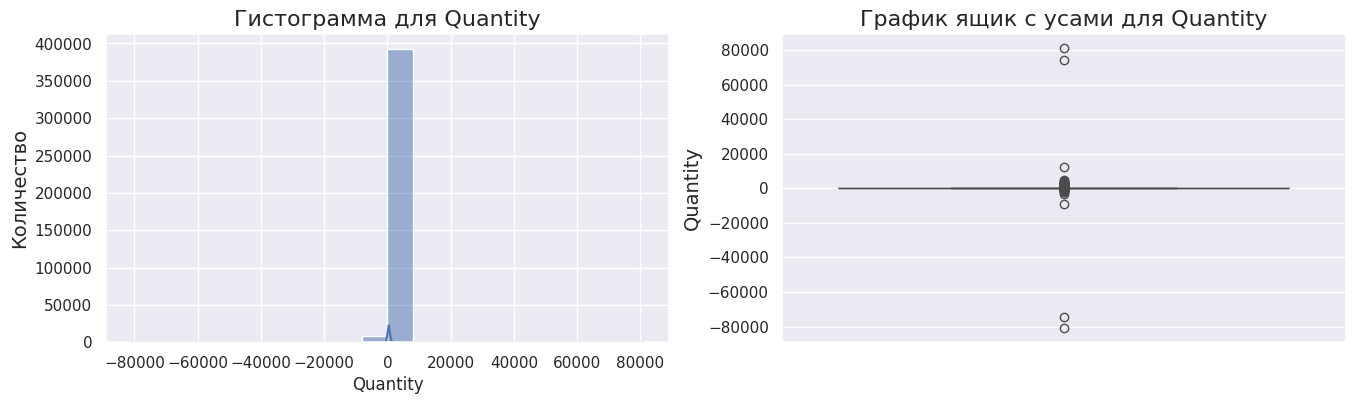

In [18]:
hist_with_wiskers(data, 'Quantity')

В колонке `Quantity` есть отрицательыне значения. Вероятно это отмены покупок или возвраты. В описании датасета сказано:  

InvoiceNo - a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  

Удалим строки с символом `c` в номере.



In [19]:
data = data[~data['InvoiceNo'].str.contains('C', na=False)]

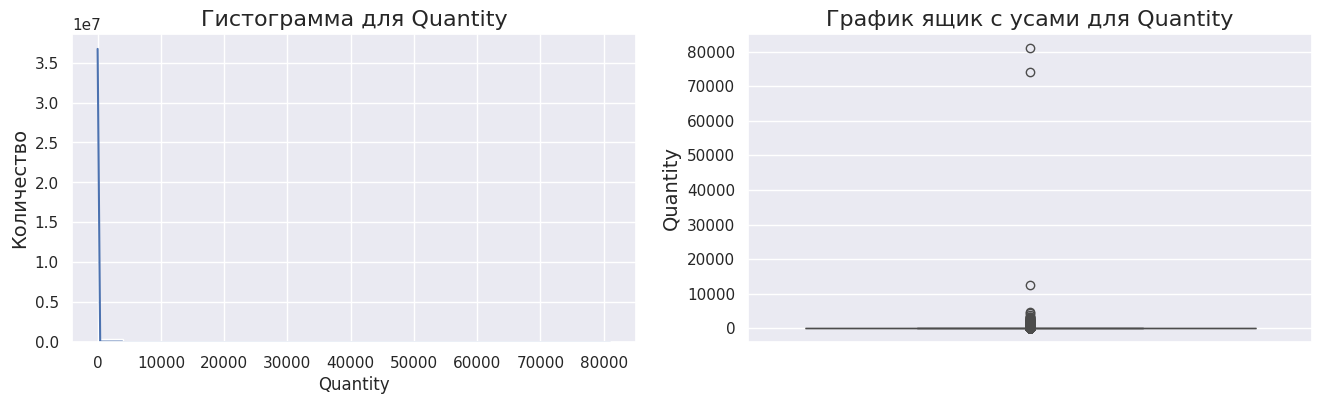

In [20]:
hist_with_wiskers(data, 'Quantity')

Уже лучше. Осталось лишь разобраться с наблюдаемыми выбросами. Порежем их по процентилям 0.05 и 0.95.

---



In [21]:
Q1 = data['Quantity'].quantile(0.05)
Q3 = data['Quantity'].quantile(0.95)
IQR = Q3 - Q1
data = data[(data['Quantity'] >= Q1 - 1.5*IQR) & (data['Quantity'] <= Q3 + 1.5*IQR)]

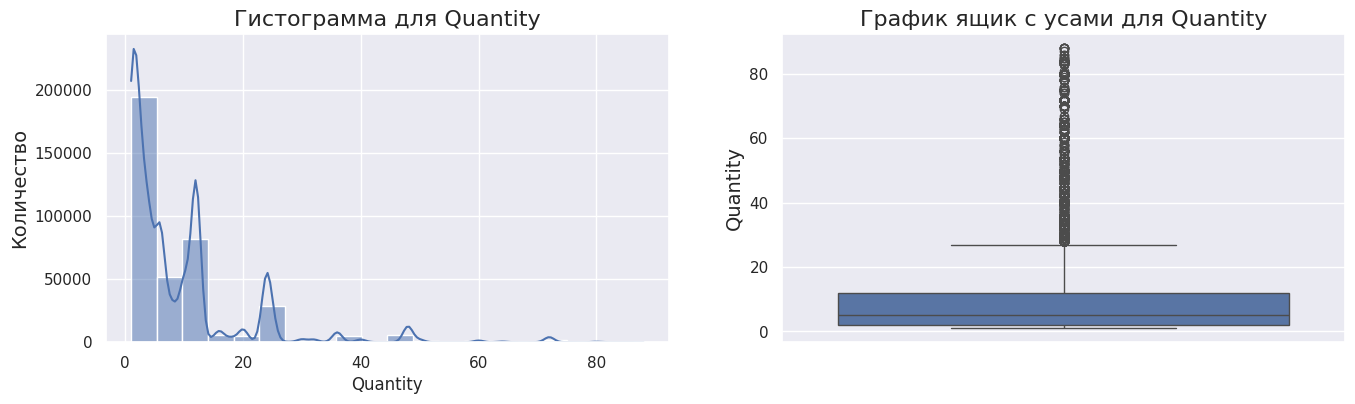

In [22]:
hist_with_wiskers(data, 'Quantity')

Исследуем так же `UnitPrice`.

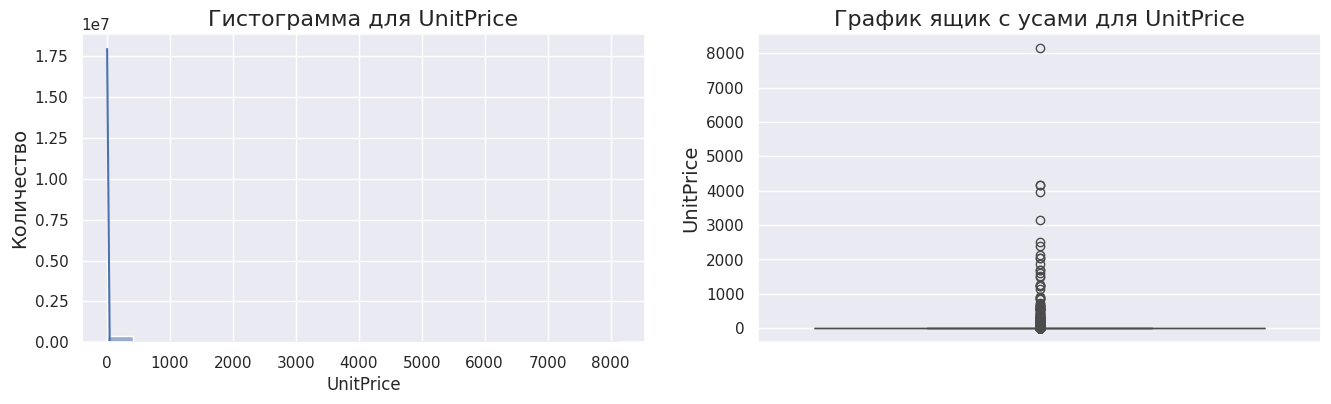

In [23]:
hist_with_wiskers(data, 'UnitPrice')

Так же наблюдаем выбросы. Обработаем аналогичнм образом с `Quantity`.

In [24]:
Q1 = data['UnitPrice'].quantile(0.05)
Q3 = data['UnitPrice'].quantile(0.95)
IQR = Q3 - Q1
data = data[(data['UnitPrice'] >= Q1 - 1.5*IQR) & (data['UnitPrice'] <= Q3 + 1.5*IQR)]

In [25]:
data[data['UnitPrice'] == 0]["UnitPrice"].count()

np.int64(33)

Так же у нас есть 33 записи с нулевой ценой. Их так же исключим.

In [26]:
data = data[data['UnitPrice'] > 0]

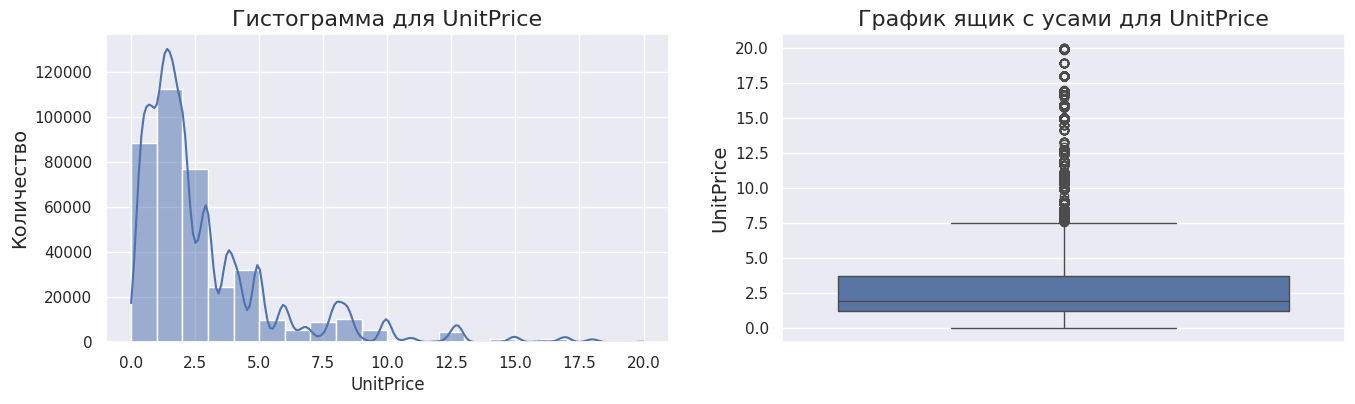

In [27]:
hist_with_wiskers(data, 'UnitPrice')

### Средняя сумма покупки

In [28]:
data['TotalPrice'] = data['Quantity']*data['UnitPrice']
data['TotalPrice'].mean()

np.float64(16.61626485943513)

### Распределение покупок по странам
Узнаем из каких стран больше всего заказов. Возможно эта информация нам в дальнейшем пригодиться.

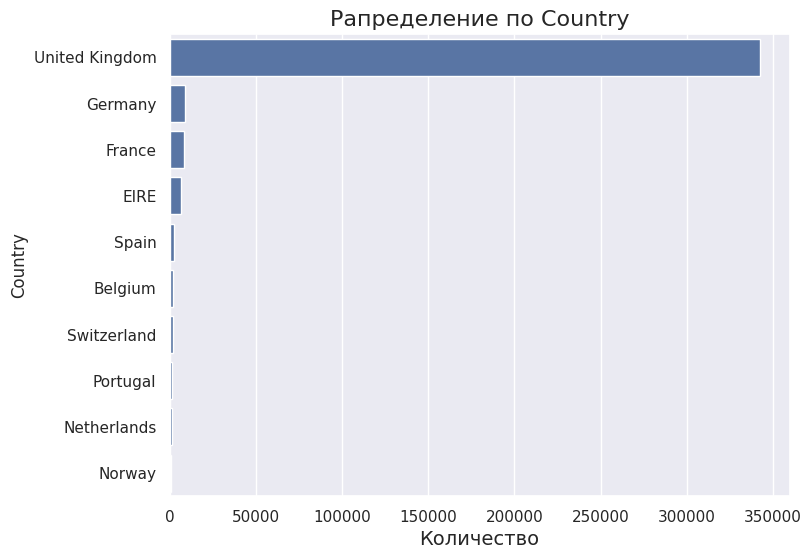

In [29]:
categoral_unique(data, 'Country')

Подавляющее число заказов из Британии.

### FMT

### Сезонность
Ресемплируем датасет по месяцам и будем рассметривать не только общее количество покупок, но и общую сумму покупок.

In [30]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['Date'] = data['InvoiceDate'].dt.date

In [31]:
data_resampled = data.set_index('InvoiceDate')

In [32]:
def plot_period(data, period):
  plt.figure(figsize=(12, 6))
  plt.subplot(311)
  plt.title(f"Общий объем продаж({period})")
  plt.xlabel(period)
  plt.ylabel('Выручка')
  data.plot(ax=plt.gca(), y='Revenue')

  plt.subplot(312)
  plt.title(f"Количество заказов({period})")
  plt.xlabel(period)
  plt.ylabel('Количество заказов')
  data.plot(ax=plt.gca(), y='InvoiceCount')
  plt.tight_layout()
  plt.show()

#### День

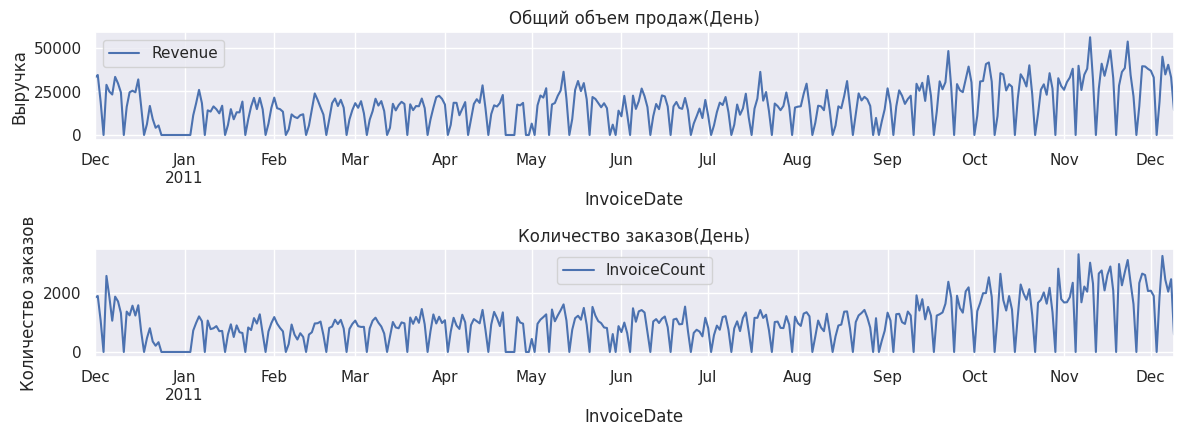

In [33]:
daily_sales = data_resampled.resample('D').agg({
    'InvoiceNo': 'size',
    'TotalPrice': 'sum'
}).rename(columns={
    'InvoiceNo': 'InvoiceCount',
    'TotalPrice': 'Revenue'
}).fillna(0)
plot_period(daily_sales, 'День')

#### Неделя

<ipython-input-34-fa589e52d559>:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  }).fillna(0)


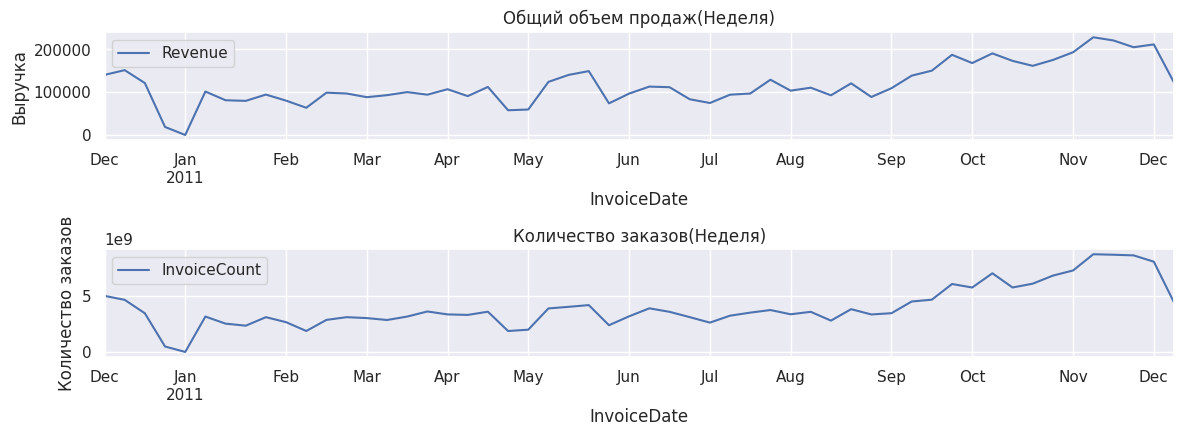

In [34]:
weekly_sales = data_resampled.resample('W-Mon').agg({
    'InvoiceNo': 'sum',
    'TotalPrice': 'sum'
}).rename(columns={
    'InvoiceNo': 'InvoiceCount',
    'TotalPrice': 'Revenue'
}).fillna(0)
plot_period(weekly_sales, 'Неделя')

#### Месяц

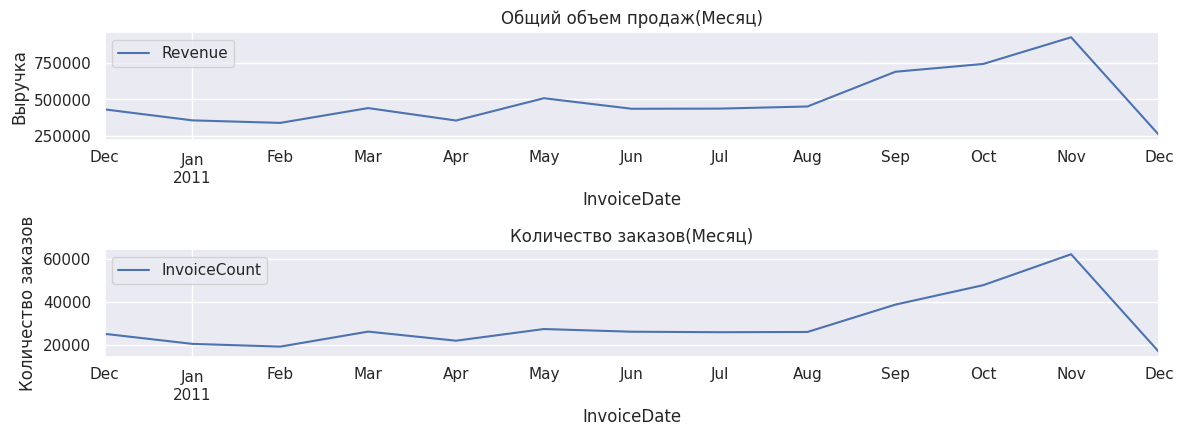

In [35]:
monthly_sales = data_resampled.resample('ME').agg({
    'InvoiceNo': 'size',
    'TotalPrice': 'sum'
}).rename(columns={
    'InvoiceNo': 'InvoiceCount',
    'TotalPrice': 'Revenue'
}).fillna(0)
plot_period(monthly_sales, 'Месяц')

 Количество заказов начинает возрастать с начала осени и достигает пика в ноябре. Рождество в Бритаии в декабре. Ну и можно понять пик заказов в декабре. Правда не очень понятно почему потом следует настолько резкий спад заказов. Неужели люди перестают покупать бытовуху в празники.


### Кластеризация
Разделим клиентов из датасета на кластеры используя DWT. Но сначала подготовим данные. И так же найдем оптимальное количество кластеров.

### Подготовка данных
Сгруппируем данные по CustomerID, добавим несколько новых признаков и нормализируем датасет простым StandardScaler.

In [36]:
data['InvoiceMonth'] = data['InvoiceDate'].dt.to_period('M')

In [37]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Date,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010-12


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383275 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     383275 non-null  object        
 1   StockCode     383275 non-null  object        
 2   Description   383275 non-null  object        
 3   Quantity      383275 non-null  int64         
 4   InvoiceDate   383275 non-null  datetime64[ns]
 5   UnitPrice     383275 non-null  float64       
 6   CustomerID    383275 non-null  int64         
 7   Country       383275 non-null  object        
 8   TotalPrice    383275 non-null  float64       
 9   Date          383275 non-null  object        
 10  InvoiceMonth  383275 non-null  period[M]     
dtypes: datetime64[ns](1), float64(2), int64(2), object(5), period[M](1)
memory usage: 35.1+ MB


Теперь создадим датасет для кластеризации.

In [39]:
data_timeseries = data.groupby(['CustomerID', pd.Grouper(key='InvoiceMonth')])['TotalPrice'].sum().unstack(fill_value=0)
data_timeseries.columns = data_timeseries.columns.map(lambda x: str(x)[:7] if x != 'CustomerID' else x)
data_timeseries

InvoiceMonth,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
CustomerID,,,,,,,,,,,,,
12347,711.79,475.39,0.00,0.00,386.65,0.00,382.52,0.00,584.91,0.0,1294.32,0.00,224.82
12348,367.68,20.40,0.00,0.00,207.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
12349,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,1417.60,0.00
12350,0.00,0.00,294.40,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
12352,0.00,0.00,296.50,345.01,0.00,0.00,0.00,0.00,0.00,512.5,0.00,231.73,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,0.00,0.00,0.00,180.60,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
18281,0.00,0.00,0.00,0.00,0.00,0.00,80.82,0.00,0.00,0.0,0.00,0.00,0.00
18282,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.21,0.0,0.00,0.00,77.84


In [40]:
scaler = StandardScaler()
data_timeseries_normalized = pd.DataFrame(scaler.fit_transform(data_timeseries.values), columns=data_timeseries.columns, index=data_timeseries.index)

In [41]:
data_timeseries_normalized.head()

InvoiceMonth,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
CustomerID,,,,,,,,,,,,,
12347,1.647981,1.199760,-0.258608,-0.306495,1.113437,-0.300492,0.777542,-0.277068,1.258159,-0.296013,1.979800,-0.300944,0.629572
12348,0.719526,-0.192938,-0.258608,-0.306495,0.454311,-0.300492,-0.282592,-0.277068,-0.277258,-0.296013,-0.306683,-0.300944,-0.229458
12349,-0.272525,-0.255382,-0.258608,-0.306495,-0.305160,-0.300492,-0.282592,-0.277068,-0.277258,-0.296013,-0.306683,1.671908,-0.229458
12350,-0.272525,-0.255382,0.700240,-0.306495,-0.305160,-0.300492,-0.282592,-0.277068,-0.277258,-0.296013,-0.306683,-0.300944,-0.229458
12352,-0.272525,-0.255382,0.707080,0.719513,-0.305160,-0.300492,-0.282592,-0.277068,-0.277258,0.645512,-0.306683,0.021551,-0.229458


In [42]:
customer_features = data.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',  # Количество уникальных покупок (чеков)
    'TotalPrice': 'sum',     # Общая сумма покупок
    #'Quantity': 'avg',
    'InvoiceDate': ['max'],  # Первая и последняя покупка
    'InvoiceMonth': ['min', 'max']  # Первая и последняя покупка
})

customer_features.columns = [
    'TotalPurchases',       # Количество покупок (чеков)
    'TotalSpent',           # Общая сумма
    #'QuantityAvg',          # Среднне число покупок в чеке
    'LastPurchaseDate',      # Дата последней покупки
    'FirstPurchaseMonth',    # Месяц первой покупки
    'LastPurchaseMonth'      # Месяц последней покупки
]

Добавим новые признаки:
* CustomerRecency - Как давно пользователь совершил последнюю покупку. Для этого найдем дату последнего заказа в датасете и прибавим к нему неделю, что бы избежать нулей. После этого вычтем из полученной даты даты последней покупки клиента.
* CustomerLifetime - Период между первой и последней покупкой клиента.

In [43]:
# Добавляем новые признаки:

customer_features['RefDate'] = customer_features['LastPurchaseDate'].max() + timedelta(days=7)
customer_features['RefDate'] = pd.to_datetime(customer_features['RefDate'])
customer_features['LastPurchaseDate'] = pd.to_datetime(customer_features['LastPurchaseDate'])
customer_features['CustomerRecency'] = pd.to_numeric((customer_features['RefDate'] - customer_features['LastPurchaseDate']).dt.days.astype('int64'))

customer_features['CustomerLifetime'] = customer_features['LastPurchaseMonth'] - customer_features['FirstPurchaseMonth']  # "Время жизни" клиента (в днях)
customer_features['CustomerLifetime'] = customer_features['CustomerLifetime'].apply(lambda x: x.n)
customer_features['CustomerLifetime'] = customer_features['CustomerLifetime'].apply(lambda x: 1 if x == 0 else x)


In [44]:
customer_features.head()

,TotalPurchases,TotalSpent,LastPurchaseDate,FirstPurchaseMonth,LastPurchaseMonth,RefDate,CustomerRecency,CustomerLifetime
CustomerID,,,,,,,,
12347,7,4060.40,2011-12-07 15:52:00,2010-12,2011-12,2011-12-16 12:50:00,8,12
12348,3,595.08,2011-04-05 10:47:00,2010-12,2011-04,2011-12-16 12:50:00,255,4
12349,1,1417.60,2011-11-21 09:51:00,2011-11,2011-11,2011-12-16 12:50:00,25,1
12350,1,294.40,2011-02-02 16:01:00,2011-02,2011-02,2011-12-16 12:50:00,316,1
12352,7,1385.74,2011-11-03 14:37:00,2011-02,2011-11,2011-12-16 12:50:00,42,9


In [45]:
features = customer_features[['TotalPurchases', 'TotalSpent', 'CustomerLifetime', 'CustomerRecency']]

In [46]:
features.head(10)

,TotalPurchases,TotalSpent,CustomerLifetime,CustomerRecency
CustomerID,,,,
12347,7,4060.40,12,8
12348,3,595.08,4,255
12349,1,1417.60,1,25
12350,1,294.40,1,316
12352,7,1385.74,9,42
12353,1,89.00,1,210
12354,1,1079.40,1,238
12355,1,339.40,1,220
12356,3,2710.63,10,29


### Определение оптимального числа кластеров методом локтя

In [47]:
def kmeans_elbow(k_range, data):
  inertia = []
  silhouette = []
  # k_range = range(1, 7)

  for k in k_range:
      kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
      kmeans.fit(data_timeseries_normalized)  # Транспонируем обратно (строки = клиенты)
      inertia.append(kmeans.inertia_)
      # silhouette.append(silhouette_score(data, kmeans.labels_, metric="euclidean"))

  # fig, ax1 = plt.subplots()

  # ax2 = ax1.twinx()
  # ax1.plot(k_range, inertia, 'o-')
  # ax2.plot(k_range, silhouette, 'x-')

  plt.plot(k_range, inertia, marker='o')
  plt.xlabel('Количество кластеров (K)')
  plt.ylabel('Inertia (SSE)')
  plt.title('Метод локтя')
  plt.show()

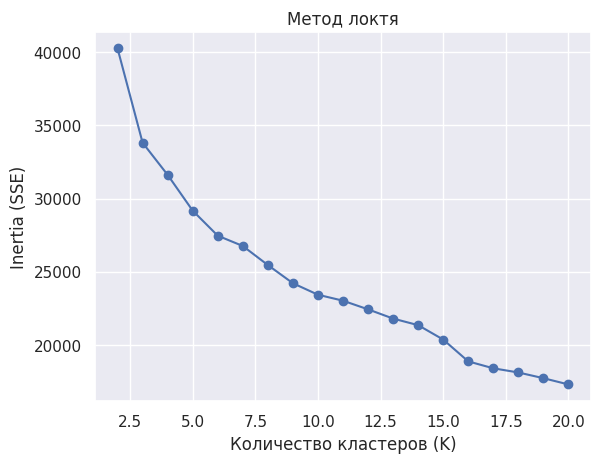

In [48]:
max_k = 20
k_range = range(2, max_k + 1)
kmeans_elbow(k_range, data_timeseries_normalized)

Честно не понимаю как визуально тут вообще можно понять какое число кластеров оптимально. Только лишь субъектвино могу сказать, что после 6 кластеров график уже не такой крутой. Поэтому и выберу 6 кластеров.

### Кластеризация K-means с DTW

In [49]:
n_clusters = 6

# Кластеризация с DTW
model = TimeSeriesKMeans(
    n_clusters=n_clusters,
    metric="dtw",  # метрика DTW
    max_iter=10,
    random_state=RANDOM_SEED
)

labels = model.fit_predict(data_timeseries_normalized)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [50]:
labels

array([4, 0, 0, ..., 0, 0, 5])

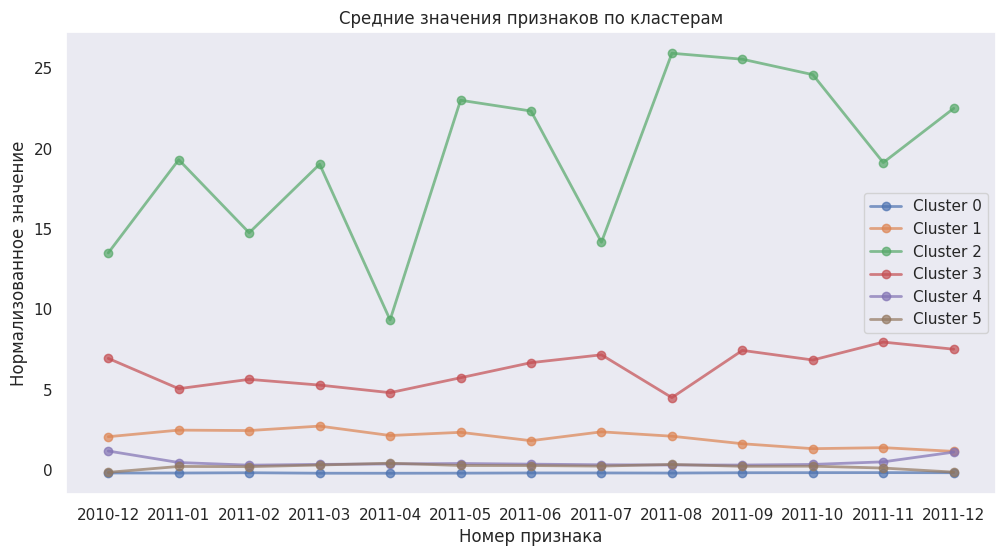

In [51]:
plt.figure(figsize=(12, 6))

# Для каждого кластера
for cluster in range(n_clusters):
    # Выбираем данные кластера (все признаки)
    cluster_data = data_timeseries_normalized[labels == cluster]

    # Визуализируем каждый признак (например, средние значения)
    plt.plot(cluster_data.mean(axis=0),  # Среднее по кластеру
             alpha=0.7,
             linewidth=2,
             marker='o',
             label=f'Cluster {cluster}')

plt.title('Средние значения признаков по кластерам')
plt.xlabel('Номер признака')
plt.ylabel('Нормализованное значение')
plt.legend()
plt.grid()
plt.show()

In [52]:
features['ClusterId'] = labels

<ipython-input-52-8fb44111866e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['ClusterId'] = labels


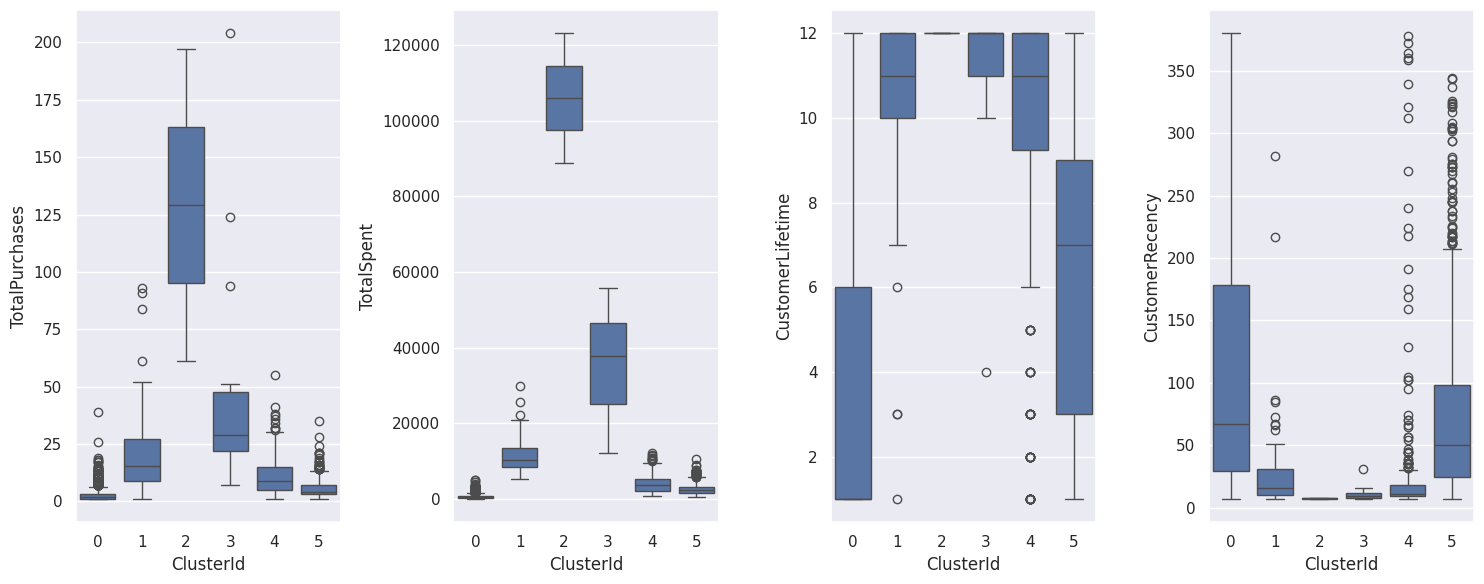

In [53]:
plt.figure(figsize=(15,6))


plt.subplot(1, 4, 1)
sns.boxplot(x=features['ClusterId'], y=features['TotalPurchases'])

plt.subplot(1, 4, 2)
sns.boxplot(x=features['ClusterId'], y=features['TotalSpent'])

plt.subplot(1, 4, 3)
sns.boxplot(x=features['ClusterId'], y=features['CustomerLifetime'])

plt.subplot(1, 4, 4)
sns.boxplot(x=features['ClusterId'], y=features['CustomerRecency'])
plt.tight_layout()
plt.show()

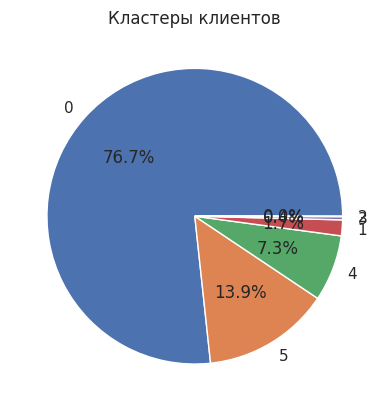

In [54]:
counts = features['ClusterId'].value_counts()

# Plot value counts as pie chart
counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Кластеры клиентов')
plt.ylabel('')
plt.show()


In [55]:
cluster_summary = features.groupby('ClusterId').mean()
print(cluster_summary)

           TotalPurchases     TotalSpent  CustomerLifetime  CustomerRecency
ClusterId                                                                  
0                2.590119     607.129208          3.657823       110.993901
1               21.567568   11580.156486         10.405405        29.067568
2              129.000000  106016.840000         12.000000         7.500000
3               50.266667   35225.007333         11.066667        11.266667
4               11.367742    3996.705903          9.851613        30.325806
5                5.366387    2590.761413          6.284034        77.601681


### Расшифровка кластеров
Попробуем опознать кластеры клиентов на основе графиков.

* 0 - Мало покупают. Мало тратят. Интервал между первой и последней покупкой маленький. Последняя покупка совершена относительно давно. Это клиенты, которые произвели покупки один-два раза и забросили сайт.
* 1 - Немного покупают недорогие товары. Пользуются сайтом давно. Это клиенты, котоыре покупают регулярно, но покупки недорогие.
* 2 - Самая жирная группа клиентов. Очень часто покупают, очень много тратят. Покупают постоянно и регулярно. Вероятно оптовики.
* 3 - Эта группа клиентов очень похожа на кластре 1. Разница только а том, что эти клиенты активнее. И больше тратят.
* 4 - Покупают редко, и небольшие покупки.
* 5 - Покупают очень редко. Давно не пользовались сайтом.

Я не знаю как должно обстоять дело в ретейле. Поэтому анализировать количетсвенные показатели мне сложно. Но если посмотреть на распределение пользователей по кластерам, то кластер с неактивными пользователи самый многочисленный - 76,7%. А самых активных пользователей так мало, что даже на пайчарте их не рассмотреть. Наверное так и должно быть.

### Вывод
Была рассмотрена задача кластеризации пользователей на примере датасета Online Retail. Кластеризация была произведена обычным TimeSeriesKMeans библиотеки tslearn.  
Количество кластеров было найдено используя метод локтя и составило 6. При рассмотрении результатов я заметил, что некоторые кластеры похожы друг на друга. Но решил сохранить градацию и не уменьшать количество кластеров.  
По результатам кластеризации ббыли построены графики кластеров и произведена их расшифровка для описания кластеров.